# Perceptron

One way to automate classification of objects using their features is to find a decision line in feature space which can separate the classes. In this activity we learn about a simple algorithm to find the decision line. It takes its inspiration from brain cells or neurons.

The earliest mathematical model of a neuron is the McCulloch-Pitts Neuron (MCP) where each input $x_i$ enters through a dendrite with synaptic strength or weight $w_i$. The neuron sums these weighted inputs ($x_iw_i$) and lets the sum, $a$ , act on an activation function, $g$. The result, $z$, is then fired through the output to other neurons. The activation function can be any thresholding function such as a step function, a sigmoid function, or even a Gaussian function.

In [1]:
import numpy as np
import pandas as pd
import cv2, glob, random, skimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from matplotlib.patches import Rectangle
from skimage import color, filters, measure, morphology

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
# plt.rcParams["text.usetex"] = True

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Training data and processing

Code for `jpg2png` function adapted from [this](https://gist.github.com/qingswu/1a58c9d66dfc0a6aaac45528bbe01b82) repository.

In [2]:
def jpg2png(folder):
    jpgimgs = glob.glob("Fruits Dataset/" + str(folder) + "/*.jpg")
    for imgs in jpgimgs:
        img = cv2.imread(imgs)
        cv2.imwrite(imgs[:-3] + 'png', img)

In [3]:
def NCC(img):
    img = img/255
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    I = R + G + B
    I[I == 0] = 100000
    r, g = R/I, G/I
    b = 1 - r - g
    return r, g, b

In [4]:
def scatter_NCC(img):
    img_r, img_g, img_b = NCC(img)[0], NCC(img)[1], NCC(img)[2]
    channels = [img_r, img_g, img_b]
    for color in channels:
        color[color < 0] = 0
    NCC_plot_colors = list(zip(img_r.flatten(), img_g.flatten(), img_b.flatten()))
    return NCC_plot_colors

In [5]:
def RGB2Lab(img):
    hueimg = skimage.color.rgb2lab(img)
    L, a, b = hueimg[:,:,0], hueimg[:,:,1], hueimg[:,:,2]
    return L, a, b

In [6]:
def hue(img):
    L, a, b = RGB2Lab(img)
    mean_a, mean_b = np.mean(a), np.mean(b)
    hue = np.degrees(np.arctan(np.mean(b)/np.mean(a)))
    if hue < 0:
        return hue + 360
    else:
        return hue

In [7]:
def fruit_select(fruit_name, data_points = 6):
    cv_img = []
    dataset = glob.glob("Fruits Dataset/" + str(fruit_name) + "/*.png")
    for img in dataset:
        n = cv2.imread(img)
        n = n[:,:,::-1] # reverse color channels
        cv_img.append(n)
        
    filtered_cv_img = random.sample(cv_img, data_points)
    return filtered_cv_img

Using the same principles for image thresholding and morphological cleaning for `regionprops`, we have

In [8]:
def fruit_thresh(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = filters.threshold_otsu(img)
    binarized_img = img > thresh
    return binarized_img

In [9]:
def feature_extract(sampleimgs, fruit_name):
    fig, ax = plt.subplots(4, 6, figsize = (12, 8), sharey = "row", constrained_layout = True)
    
    for i, img in enumerate(sampleimgs):
        # imshow the fruits
        ax[0,i].imshow(img)
        ax[0,i].axis("off")
        ax[0,i].set_title("{} {}".format(fruit_name, i+1))
        
        # feature 1 - NCC coordinates
        r, g, b = NCC(img)
        x_vals = np.linspace(0, 1, 1000)
        ax[1,i].scatter(r, g, alpha = 0.2, s = 1.5, c = scatter_NCC(img))
        ax[1,i].scatter(np.mean(r), np.mean(g), s = 60, color = "blue", marker = "x")
        ax[1,i].plot(x_vals, 1 - x_vals, color = "darkgray", linestyle = "--")
        ax[1,i].set_xlabel("$r$")
        ax[1,0].set_ylabel("$g$")
        
        # feature 2 - CIELab coordinates
        L, a, b = RGB2Lab(img)
        ax[2,i].scatter(a, b, alpha = 0.2, s = 1.5, c = scatter_NCC(img))
        ax[2,i].scatter(np.mean(a), np.mean(b), s = 60, color = "blue", marker = "x")
        ax[2,i].axhline(0, color = "darkgray", linestyle = "--")
        ax[2,i].axvline(0, color = "darkgray", linestyle = "--")
        ax[2,i].set_title("Hue = {:.2f}".format(hue(img)))
        ax[2,i].set_xlim(-30, 30)
        ax[2,i].set_ylim(-50, 50)
        ax[2,i].set_xlabel("$a^*$")
        ax[2,0].set_ylabel("$b^*$")
        
        # feature 3 - morphological cleaning and eccentricity
        thresholded = fruit_thresh(img)
        cleaned = morphology.binary_opening(morphology.binary_closing(thresholded))
        cleaned = morphology.remove_small_holes(cleaned, area_threshold = 100)
        
        labels = measure.label(cleaned, background = 1) # setting background fixes centroids
        labels = morphology.remove_small_objects(labels, min_size = 500)
        props = measure.regionprops(labels)
        results = measure.regionprops_table(labels, properties = ("area", "centroid", "eccentricity"))
        df = pd.DataFrame(results)
        
        area = df["area"].to_numpy()
        centroidx = df["centroid-1"].to_numpy()
        centroidy = df["centroid-0"].to_numpy()
        eccentricity = df["eccentricity"].to_numpy()
        
        ax[3,i].imshow(cleaned, cmap = "cividis_r")
        ax[3,i].scatter(centroidx, centroidy, color = "red")
        ax[3,i].set_title("$\epsilon$ = {:.3f}".format(eccentricity[0]), y = -0.18)
        ax[3,i].axis("off")

In [10]:
def feature_extract_data(sampleimgs):
    
    hue_data, eccentricity_data = [], []
    
    for img in sampleimgs:
        # mean a*b* coordinates - hue of image
        hue_data.append(hue(img))
        
        # regionprops - eccentricity
        thresholded = fruit_thresh(img)
        cleaned = morphology.binary_opening(morphology.binary_closing(thresholded))
        cleaned = morphology.remove_small_holes(cleaned, area_threshold = 100)
        
        labels = measure.label(cleaned, background = 1) # setting background fixes centroids
        labels = morphology.remove_small_objects(labels, min_size = 500)
        regionprops = measure.regionprops(labels)
        
        for prop in regionprops:
            eccentricity_data.append(prop.eccentricity)
        
    return hue_data, eccentricity_data

***

## Feature extraction of some fruits

Images adapted from [Fruits 360](https://www.kaggle.com/datasets/moltean/fruits), a dataset repository of images containing fruits and vegetables. Hue and eccentricity were considered for this activity. The color of objects can also be visualized and quantified by using the CIELAB color space. The 3-dimensional color space is built-up from three axes that are perpendicular to one another. Hue and chroma can be visualized and quantified by using the *a*b-plane of the CIELAB color space. The hue angle range starts, by definition, at the positive side of the $a^*$-axis and goes counter-clockwise. This implies that red has a hue angle of 0°. A full circle goes from 0° to 360°. This means that $$\text{hue} = \tan^{-1} \frac{b^*}{a^*}$$ which will be used later for the feature space extraction.

In [11]:
avocado = fruit_select("Avocado")

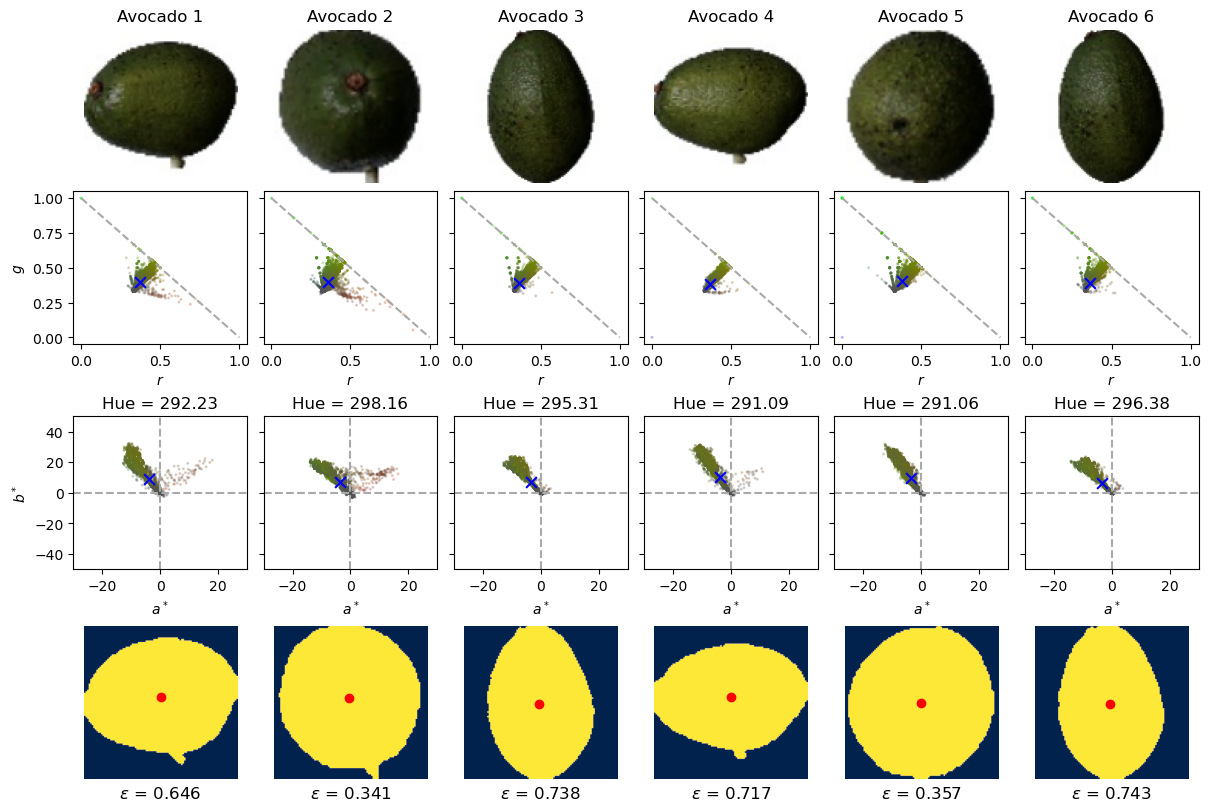

In [12]:
feature_extract(avocado, "Avocado")
plt.savefig("avocado features.png")

In [13]:
banana = fruit_select("Banana")

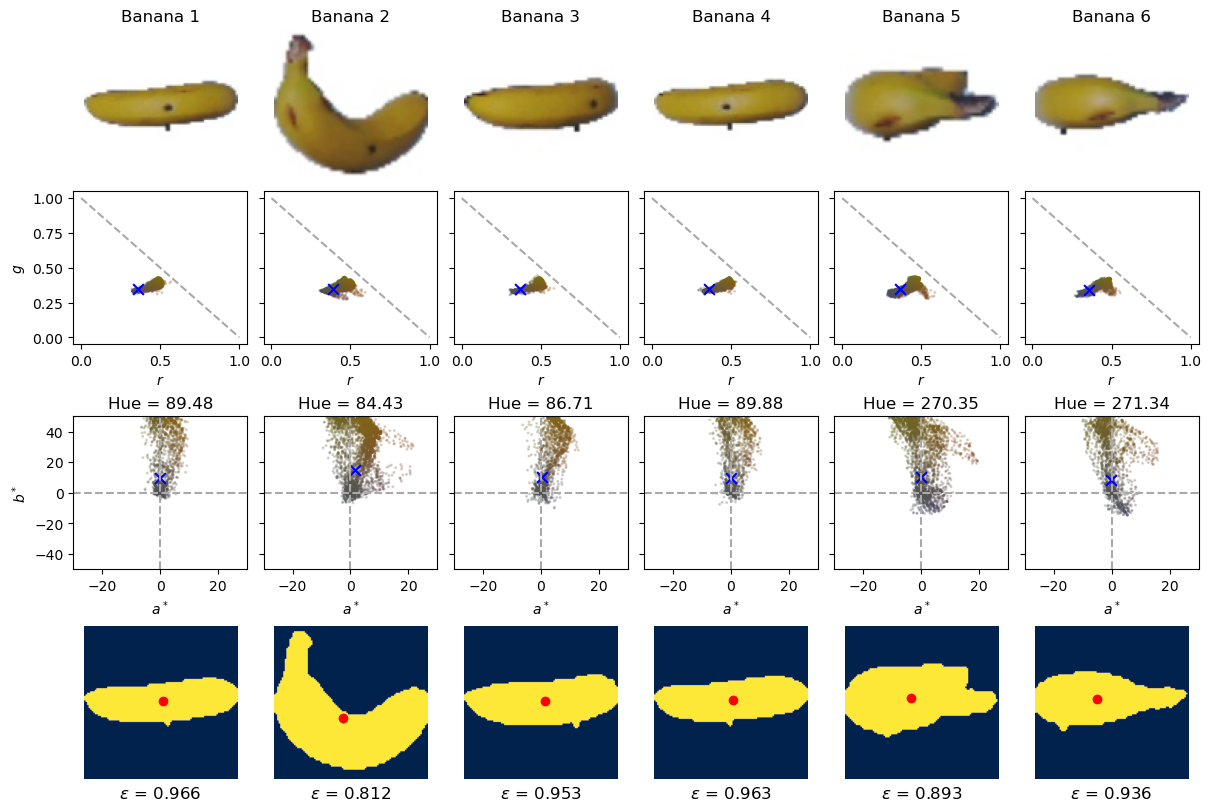

In [14]:
feature_extract(banana, "Banana")
plt.savefig("banana features.png")

In [15]:
eggplant = fruit_select("Eggplant")

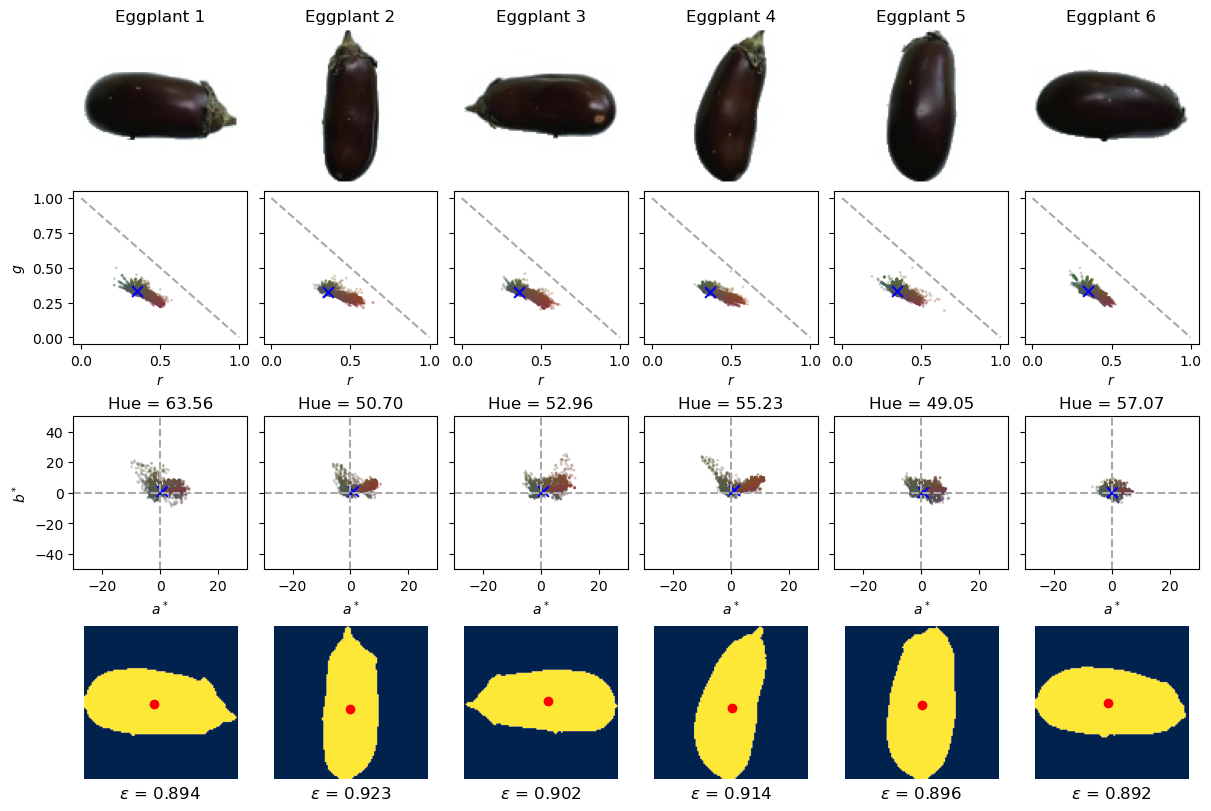

In [16]:
feature_extract(eggplant, "Eggplant")
plt.savefig("eggplant features.png")

In [17]:
lychee = fruit_select("Lychee")

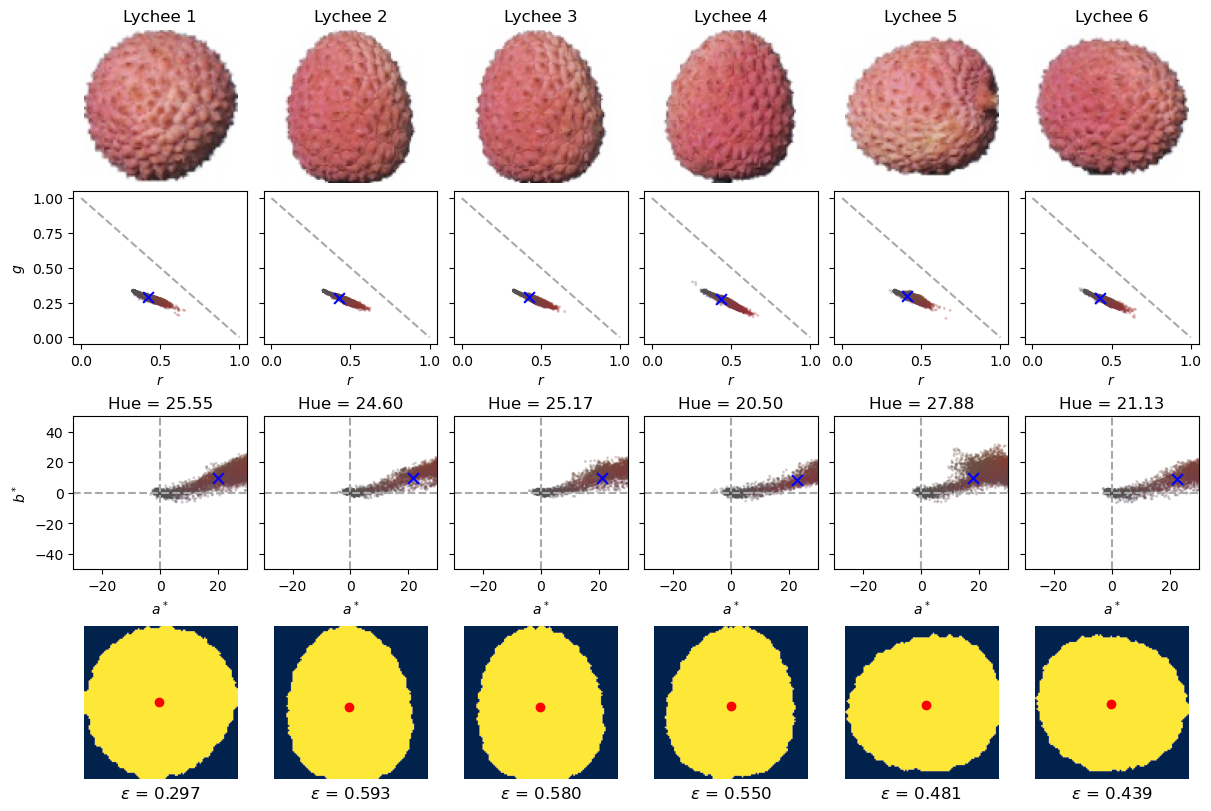

In [18]:
feature_extract(lychee, "Lychee")
plt.savefig("lychee features.png")

In [19]:
orange = fruit_select("Orange")

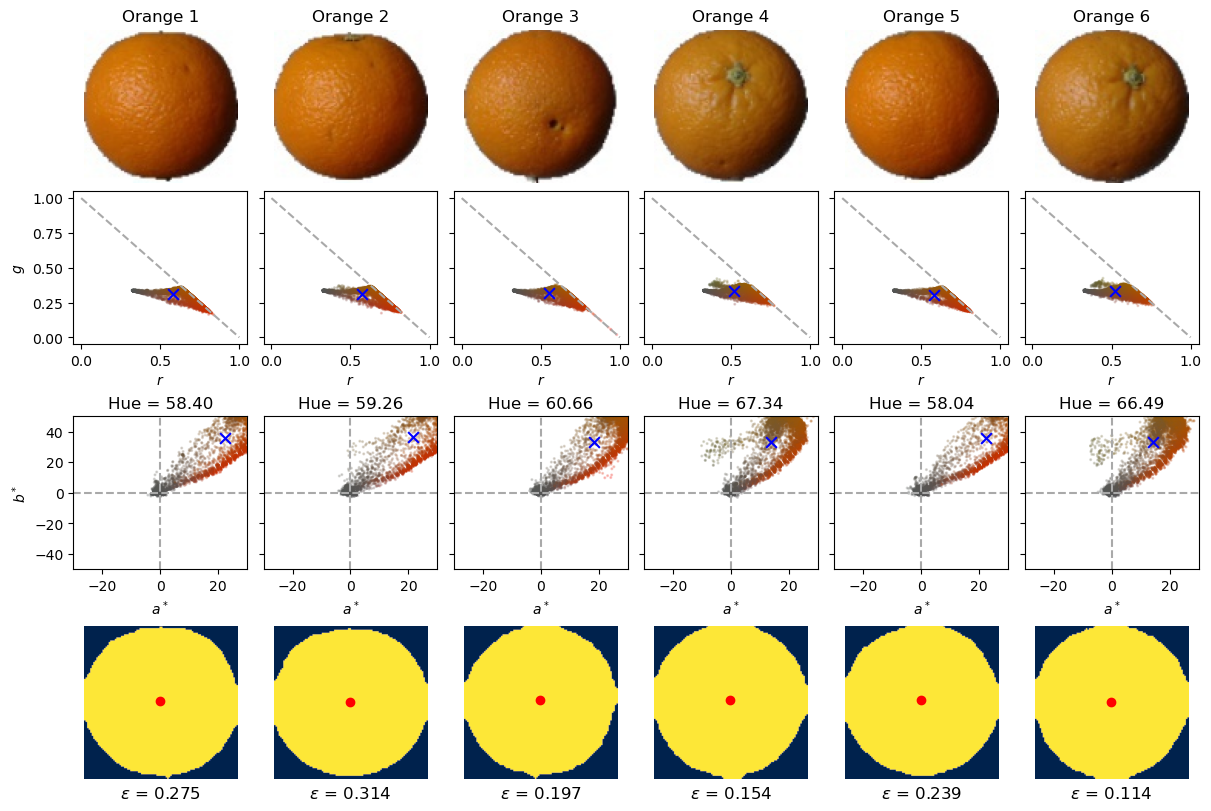

In [20]:
feature_extract(orange, "Orange")
plt.savefig("orange features.png")

### Comparisons among fruits

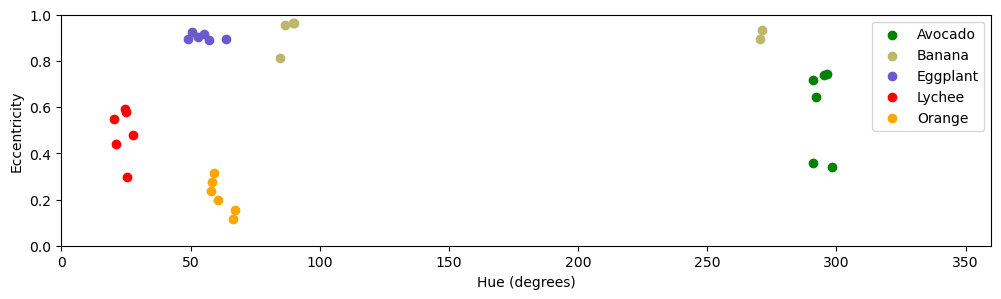

In [21]:
fruits = [avocado, banana, eggplant, lychee, orange]
fruit_names = ["Avocado", "Banana", "Eggplant", "Lychee", "Orange"]
fruit_colors = ["green", "darkkhaki", "slateblue", "red", "orange"] 
plt.figure(figsize = (12, 3))

for fruit, tag, shade in zip(fruits, fruit_names, fruit_colors):
    hues = feature_extract_data(fruit)[0]
    eccentricities = feature_extract_data(fruit)[1]
    plt.scatter(hues, eccentricities, label = tag, color = shade)
    plt.xlabel("Hue (degrees)")
    plt.ylabel("Eccentricity")
    plt.xlim(0, 360)
    plt.ylim(0, 1)
    plt.legend()

***
## Perceptron algorithm

Suppose we have two classes of **objects**, $w_1$ and $w_2$, which are both described by **features** $x_1$ and $x_2$. In the context of our data, $w_1$ may be bananas, $w_2$ may be oranges, $x_1$ is color and $x_2$ is eccentricity. We follow some notation rules as follows

- Subscripts of $x$ are the **feature components**. Corresponding weights $w$ will be indicated by subscripts as well. Thus $x_j$ and $w_j$ are the $j$th feature and corresponding synaptic weight, respectively. The feature vector is denoted by $$x=\begin{bmatrix} x_1 & x_2 \end{bmatrix}^T$$.
- Superscripts in $x$ indicate the **input sample number**. The corresponding perceptron output z is also indicated by a superscript. Thus $x^i_j$ indicate the $j$th feature of the $i$th sample while $z^i$ is the output of the perceptron due to input $x^i$.

### Perceptron weight change rule
For each sample $i$,
1. Include a **constant bias input** $x_0=1$ in all sample inputs. Thus, a two-feature vector will become three such that $\begin{bmatrix} 1 & x_1 & x_2 \end{bmatrix}^T$. Let $d^i$ be the class label of the feature: $d^i=1$ if the feature belongs to class 1, otherwise, -1 if it belongs to class 2.
2. Initialize the weights to some random number. Note the $x_o$ will have its corresponding weight $w_o$.
3. Calculate the **perceptron input** using steps 1 and 2. We use a step function as our **thresholding function** defined as $$z=g(a)=\begin{cases} 1, & \text{if} \quad a >= 0 \\ -1, &\text{otherwise} \end{cases}$$ as the perceptron output.
4. Calculate the weight change $\Delta w_j$ as $$\Delta w_j = \eta \left(d^i - z^i\right)x^i_j$$ where $\eta$ is the **learning rate**  and is assigned a number between 0 and 1.
5. Update the weights as $w_j = w_j + \Delta w_j$.
6. Iterate through samples. Stop when $d^i - z^i$ is small or a number of iterations is reached.

For reference, the sequence from input to output follows as
1. Taking the dot product between the features and weights, i.e. $$a = x_1w_1 + x_2w_2 + \cdots + x_nw_n = \sum x_iw_i = x^Tw$$.
2. The output $z$ is then equal to the output of an activation/threshold function acting on $a$ given by $z=g(a)$.

In [22]:
def unit_step_function(a):
    return np.where(a>=0, 1, -1)

In [23]:
def perceptron(data1, data2, learning_rate = 0.01, epoch = 1000):
    samples = np.hstack([data1, data2])
    features = np.array(samples).T # samples - take the four features from two objects!
    bias_element = np.ones(np.shape(features)[0]).reshape(np.shape(features)[0], -1) # add a bias of 1.0
    features = np.hstack((bias_element, features))
    
    # initialize labels for both classes
    labels = np.zeros(np.shape(features)[0])
    labels[0:np.shape(features)[0]//2] = -1
    labels[np.shape(features)[0]//2:] = 1
    
    # initialize weights to random numbers
    weights = np.random.random(len(features[0])) 
    
    # apply weight change rule
    for time in range(epoch):
        for i, x in enumerate(features):
            a = np.dot(x.T, weights)
            output = unit_step_function(a)
            deltaw = learning_rate * (labels[i] - output) * x
            weights += deltaw
    
    return weights

In [24]:
def line_params(weights):
    A, B, C = weights[1], weights[2], -weights[0]
    slope = -A/B
    intercept = C/B
    return slope, intercept

***
## Fruit classifications

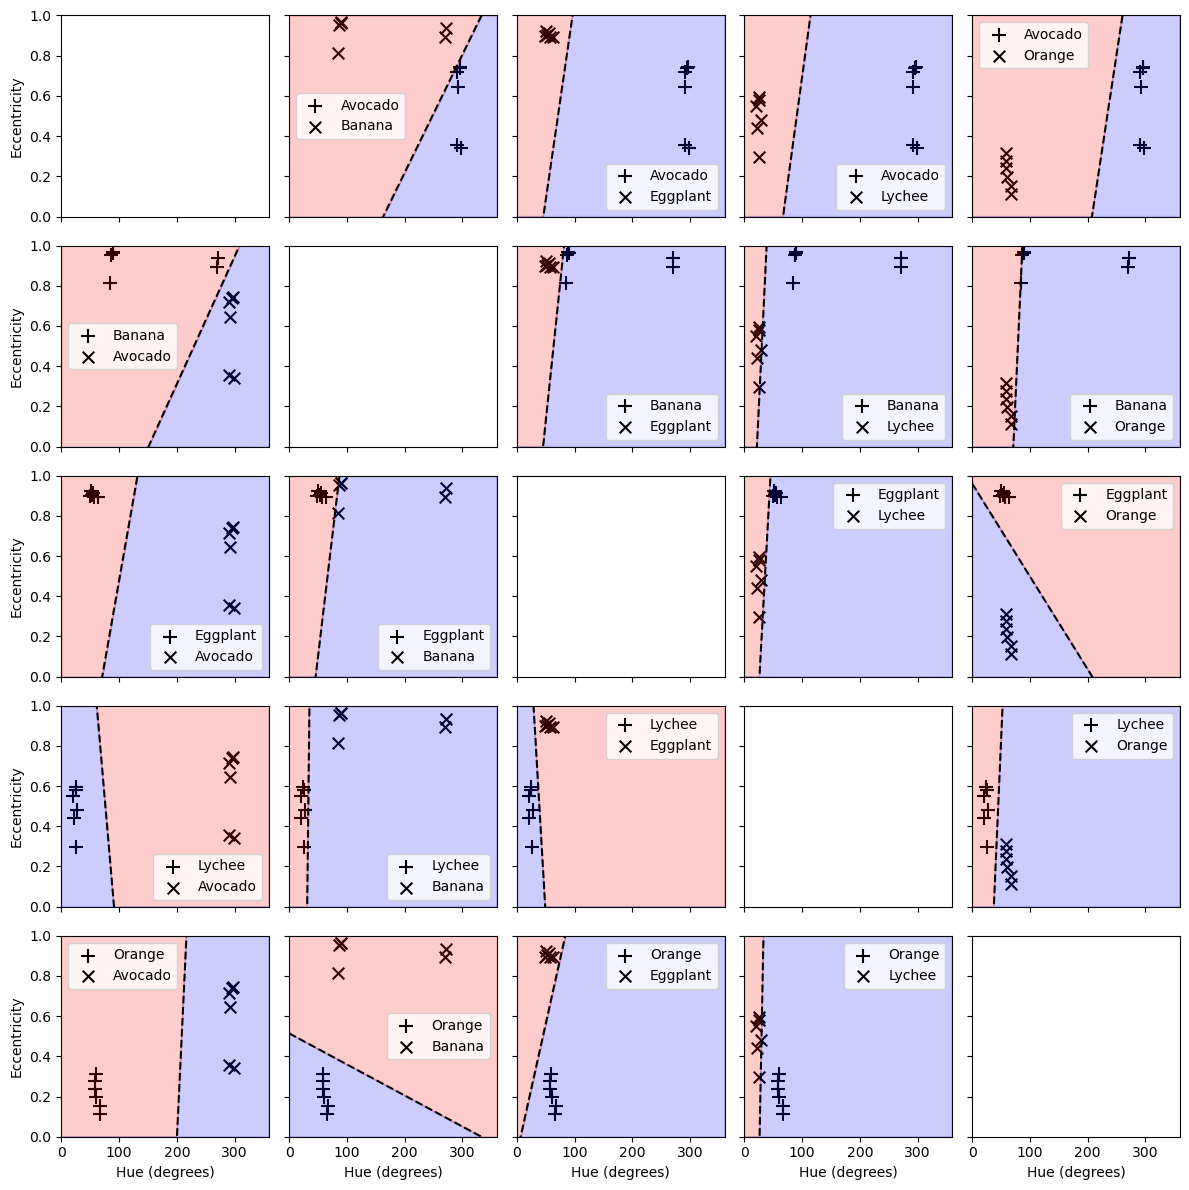

In [25]:
fig,ax = plt.subplots(5, 5, figsize = (12, 12), sharex = True, sharey = True, tight_layout = True)

for (i, a), tag1 in zip(enumerate(fruits), fruit_names):
    for (j, b), tag2 in zip(enumerate(fruits), fruit_names):
        data1, data2 = feature_extract_data(a), feature_extract_data(b)
        classifier = perceptron(data1, data2)
        slope, intercept = line_params(classifier)
        xvals = np.linspace(0, 360, 1000)
        yvals = slope*xvals + intercept
        if i == j:
            pass
        else:
            ax[i,j].scatter(data1[0], data1[1], color = "black", marker = "+", s = 90, label = tag1)
            ax[i,j].scatter(data2[0], data2[1], color = "black", marker = "x", s = 70, label = tag2)
            ax[i,j].plot(xvals, yvals, color = "black", linestyle = "--")
            ax[i,j].fill_between(xvals, yvals, 0, color = "blue", alpha = 0.2, interpolate = True)
            ax[i,j].fill_between(xvals, yvals, 1, color = "red", alpha = 0.2, interpolate = True)
            ax[i,j].set_xlim(0, 360)
            ax[i,j].set_ylim(0, 1)
            ax[i,j].legend()
        if i == 4:
            ax[i,j].set_xlabel("Hue (degrees)")
        if j == 0:
            ax[i,j].set_ylabel("Eccentricity")
            
fig.savefig("fruit classifications.png")

***
## Feature extraction of stars

The purpose of making the [dataset](https://www.kaggle.com/datasets/deepu1109/star-dataset) is to prove that the stars follows a certain graph in the celestial Space, specifically called **Hertzsprung-Russell Diagram** so that we can classify stars by plotting its features based on that graph.

The dataset is created based on several equations in astrophysics. They are given below:
1. Stefan-Boltzmann's law of Black body radiation (to find the luminosity of a star)
2. Wienn's Displacement law (for finding surface temperature of a star using wavelength)
3. Absolute magnitude relation
4. Radius of a star using parallax

In [26]:
# load dataset
stars_dataset = pd.read_csv("Stars Dataset.csv")
stars_dataset = pd.DataFrame(stars_dataset)

In [27]:
stars_dataset

,Temperature (K),Luminosity (L/Lo),Radius (R/Ro),Absolute magnitude (Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,White,A
238,9235,404940.000000,1112.0000,-11.23,5,White,A


In [28]:
temperature = stars_dataset["Temperature (K)"].to_numpy()
luminosity = stars_dataset["Luminosity (L/Lo)"].to_numpy()
abs_magnitude = stars_dataset["Absolute magnitude (Mv)"].to_numpy()

spectral_class = stars_dataset["Spectral Class"].to_numpy()
star_type = stars_dataset["Star type"].to_numpy()

### Spectral classes

Most stars are currently classified under the **Morgan–Keenan (MK)** system using the letters O, B, A, F, G, K, and M, a sequence from the hottest (O type) to the coolest (M type). Each letter class is then subdivided using a numeric digit with 0 being hottest and 9 being coolest (e.g., A8, A9, F0, and F1 form a sequence from hotter to cooler).

In [29]:
O_SC = np.where(spectral_class == "O")
B_SC = np.where(spectral_class == "B")
A_SC = np.where(spectral_class == "A")
F_SC = np.where(spectral_class == "F")
G_SC = np.where(spectral_class == "G")
K_SC = np.where(spectral_class == "K")
M_SC = np.where(spectral_class == "M")

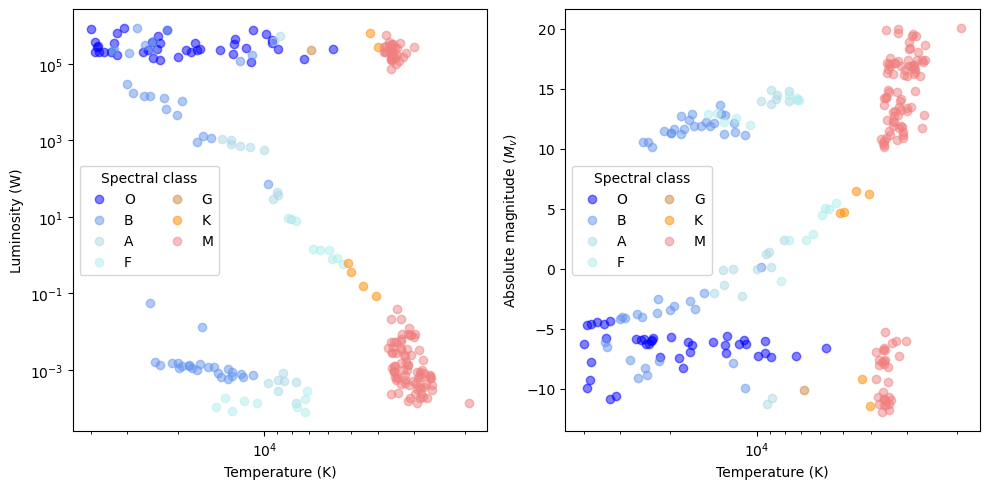

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5), tight_layout = True)

spectrums = [O_SC, B_SC, A_SC, F_SC, G_SC, K_SC, M_SC]
spectrum_label = ["O", "B", "A", "F", "G", "K", "M"]
color_spectrum = ["blue", "cornflowerblue", "lightblue", "paleturquoise", "peru", "darkorange", "lightcoral"]

for (i, spec), tag, color in zip(enumerate(spectrums), spectrum_label, color_spectrum):
    
    ax[0].scatter(temperature[spec], luminosity[spec], alpha = 0.5, label = tag, c = color)
    ax[0].legend(title = "Spectral class", ncol = 2)
    ax[0].set_xlabel("Temperature (K)")
    ax[0].set_ylabel("Luminosity (W)")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].invert_xaxis()
    
    ax[1].scatter(temperature[spec], abs_magnitude[spec], alpha = 0.5, label = tag, c = color)
    ax[1].legend(title = "Spectral class", ncol = 2)
    ax[1].set_xlabel("Temperature (K)")
    ax[1].set_ylabel("Absolute magnitude ($M_v$)")
    ax[1].set_xscale("log")
    ax[1].invert_xaxis()
    
fig.savefig("spectral classes.png")

### Star types
Some descriptions adapted from [NASA Science Universe Exploration](https://universe.nasa.gov/stars/types/#otp_main_sequence_stars).

1. **Red dwarfs** are the smallest main sequence stars – just a fraction of the Sun’s size and mass. They’re also the coolest, and appear more orange in color than red.
2. **Brown dwarfs** form the same way as main sequence stars, from gas and dust clumps in nebulae, but they never gain enough mass to do fusion on the scale of a main sequence star. Others may form like planets, from disks of gas and dust around stars.
3. After a red giant has shed all its atmosphere, only the core remains. Scientists call this kind of stellar remnant a **white dwarf**. A white dwarf is usually Earth-size but hundreds of thousands of times more massive. A teaspoon of its material would weigh more than a pickup truck. A white dwarf produces no new heat of its own, so it gradually cools over billions of years.
4. **Main sequence stars** make up around 90% of the universe’s stellar population. They range in luminosity, color, and size – from a tenth to 200 times the Sun’s mass – and live for millions to billions of years.
5. **Supergiants** are among the most massive and most luminous stars. Supergiant stars occupy the top region of the Hertzsprung–Russell diagram with absolute visual magnitudes between about −3 and −8. The temperature range of supergiant stars spans from about 3,400 K to over 20,000 K.
6. A **hypergiant** is a very rare type of star that has an extremely high luminosity, mass, size and mass loss because of its extreme stellar winds.

In [31]:
red_dwarf = np.where(star_type == 0)
brown_dwarf = np.where(star_type == 1)
white_dwarf = np.where(star_type == 2)
main_sequence = np.where(star_type == 3)
supergiant = np.where(star_type == 4)
hypergiant = np.where(star_type == 5)

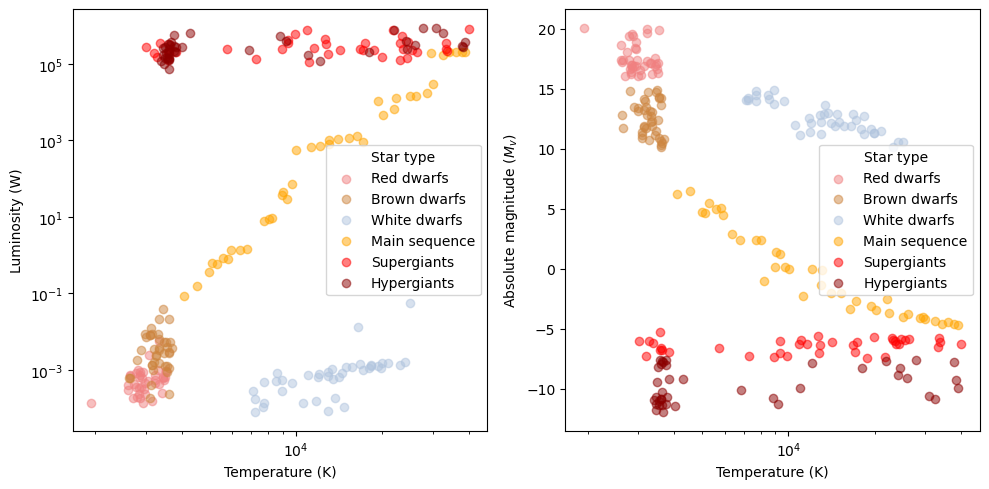

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5), tight_layout = True)

star_classes = [red_dwarf, brown_dwarf, white_dwarf, main_sequence, supergiant, hypergiant]
star_names = ["Red dwarfs", "Brown dwarfs", "White dwarfs", "Main sequence", "Supergiants", "Hypergiants"]
color_spectrum = ["lightcoral", "peru", "lightsteelblue", "orange", "red", "darkred"]

for (i, types), tag, color in zip(enumerate(star_classes), star_names, color_spectrum):
    
    ax[0].scatter(temperature[types], luminosity[types], alpha = 0.5, label = tag, c = color)
    ax[0].legend(title = "Star type")
    ax[0].set_xlabel("Temperature (K)")
    ax[0].set_ylabel("Luminosity (W)")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].invert_xaxis()
    
    ax[1].scatter(temperature[types], abs_magnitude[types], alpha = 0.5, label = tag, c = color)
    ax[1].legend(title = "Star type")
    ax[1].set_xlabel("Temperature (K)")
    ax[1].set_ylabel("Absolute magnitude ($M_v$)")
    ax[1].set_xscale("log")
    ax[1].invert_xaxis()
    
fig.savefig("star stypes.png")

***
## Star classifications

Guide for comparison: temperature and luminosity

In [33]:
# preparation for peceptron algorithm - star features
def joint_star_data(star_type):
    temperatures, luminosities = temperature[star_type], luminosity[star_type]
    return temperatures.tolist(), luminosities.tolist()

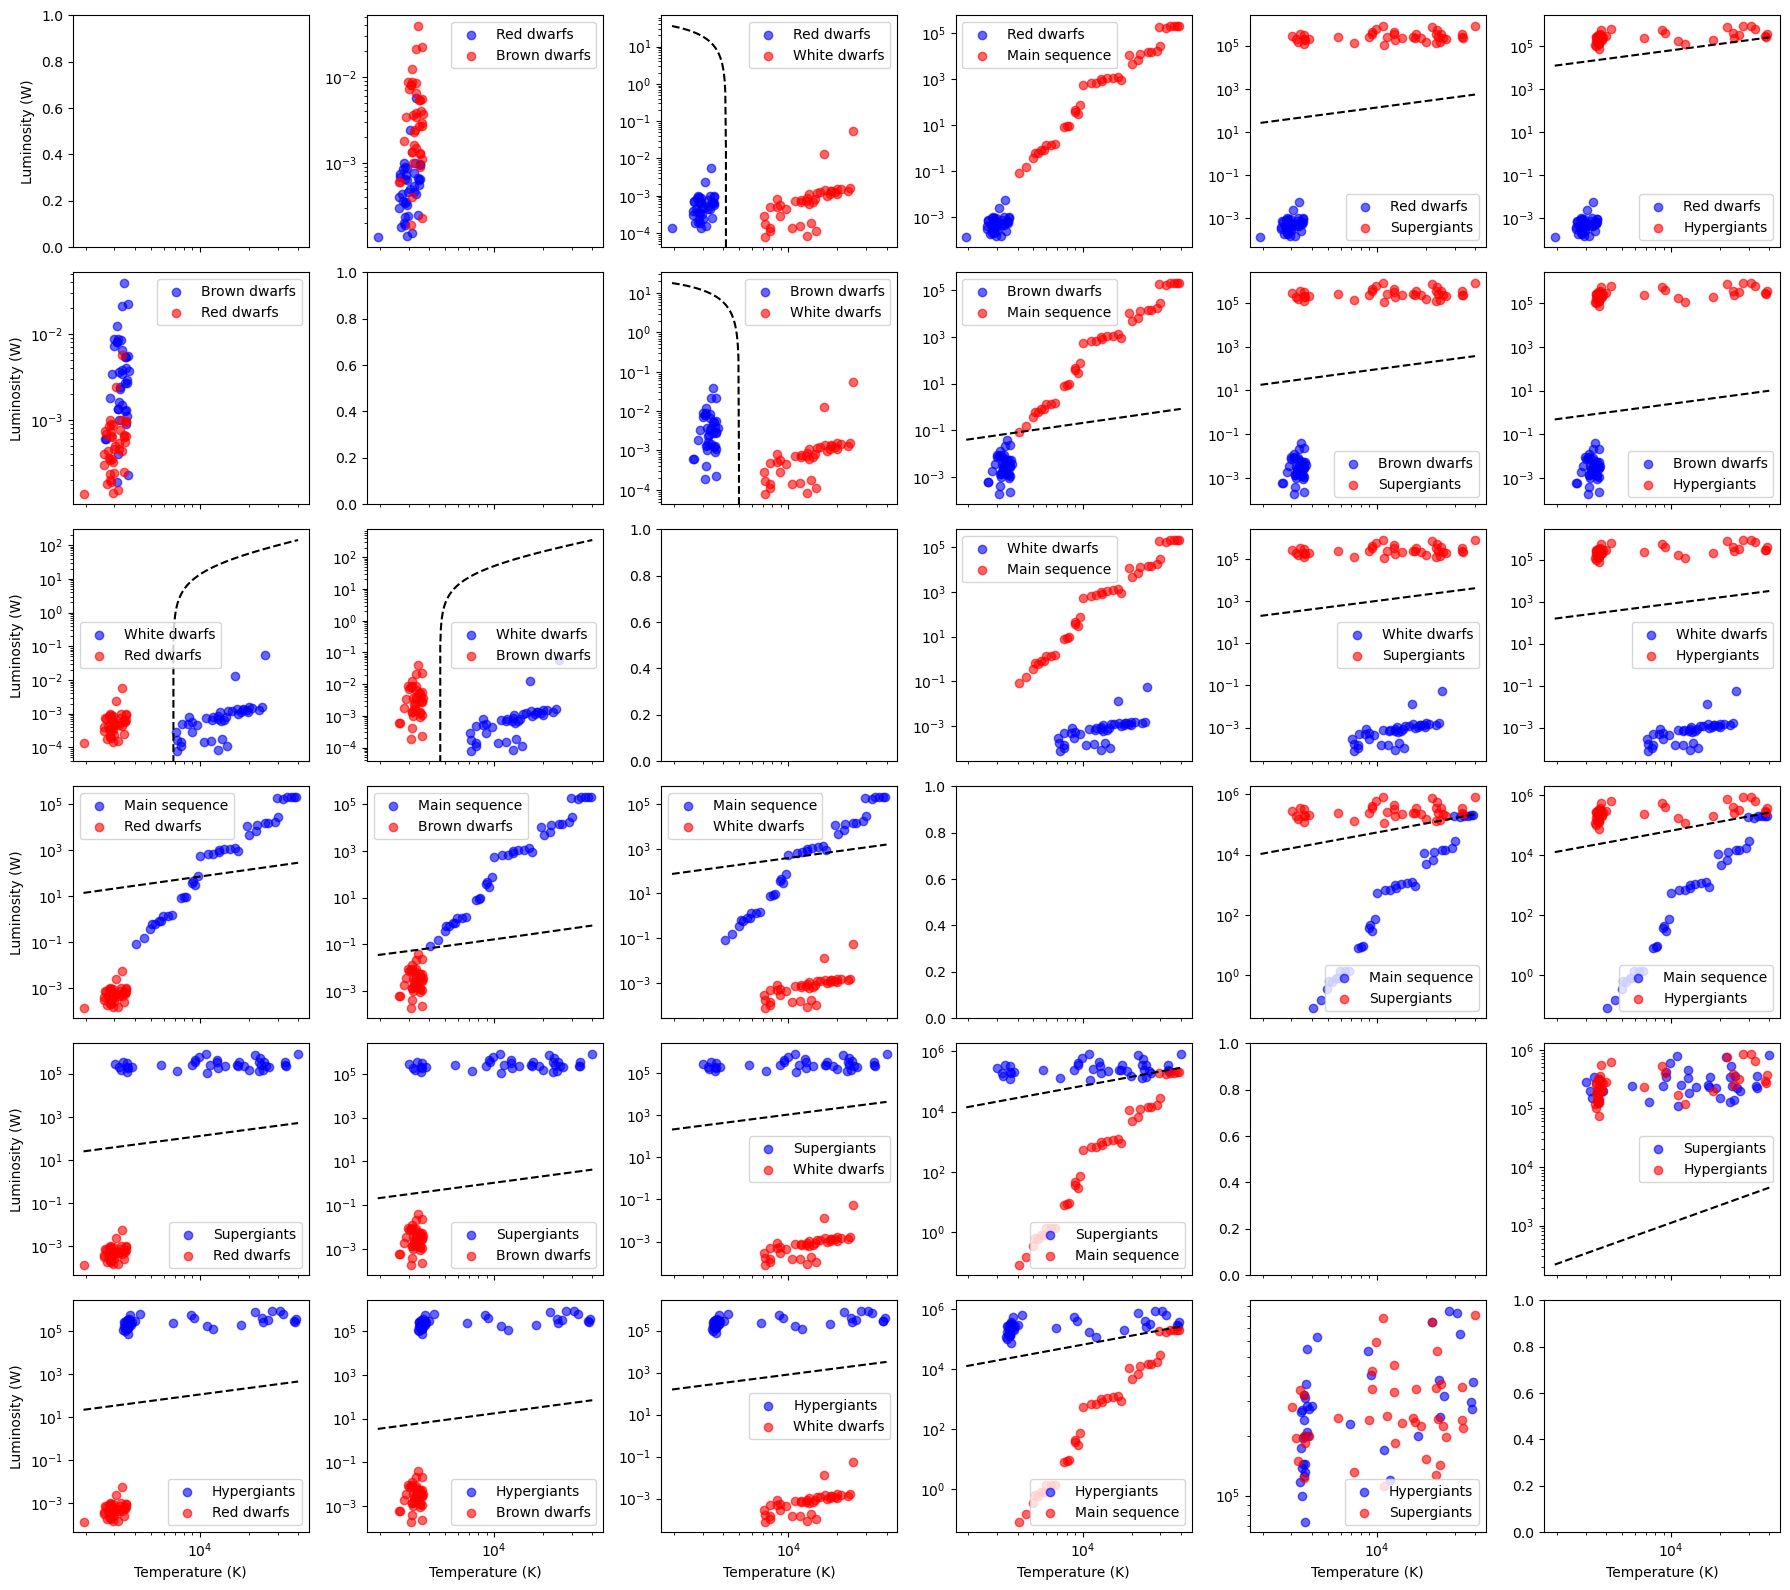

In [34]:
fig,ax = plt.subplots(6, 6, figsize = (18, 16), sharex = "col", tight_layout = True)

for (i, a), tag1 in zip(enumerate(star_classes), star_names):
    for (j, b), tag2 in zip(enumerate(star_classes), star_names):
        data1, data2 = joint_star_data(a), joint_star_data(b)
        classifier = perceptron(data1, data2, learning_rate = 0.001, epoch = 2500)
        slope, intercept = line_params(classifier)
        xvals = np.linspace(temperature.min(), temperature.max(), 1000)
        yvals = slope*xvals + intercept
        if i == j:
            pass
        else:
            ax[i,j].scatter(data1[0], data1[1], color = "blue", alpha = 0.6, label = tag1)
            ax[i,j].scatter(data2[0], data2[1], color = "red", alpha = 0.6, label = tag2)
            ax[i,j].plot(xvals, yvals, color = "black", linestyle = "--")
            ax[i,j].set_xscale("log")
            ax[i,j].set_yscale("log")
            ax[i,j].legend()
        if i == 5:
            ax[i,j].set_xlabel("Temperature (K)")
        if j == 0:
            ax[i,j].set_ylabel("Luminosity (W)")
            
fig.savefig("star classifications.png")

***
## References
1. https://stackoverflow.com/questions/62969818/finding-each-centroid-of-multiple-connected-objects
2. https://stackoverflow.com/questions/67557518/why-lenmeasure-regionpropsimgl-gives-me-a-wrong-number-of-objects
3. https://gist.github.com/qingswu/1a58c9d66dfc0a6aaac45528bbe01b82
4. https://www.ulprospector.com/knowledge/10780/pc-the-cielab-lab-system-the-method-to-quantify-colors-of-coatings/
5. https://www.niwa.nu/2013/05/math-behind-colorspace-conversions-rgb-hsl/
6. https://maviccprp.github.io/a-perceptron-in-just-a-few-lines-of-python-code/